<a href="https://colab.research.google.com/github/danb-neo4j/patient_journey/blob/main/patientJourney_nodeSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient Journey Demo: Patient Journey Analysis Using Node Similarity
In this notebook we will use the Neo4j Graph Data Science (GDS) [Node Similarity](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/) algorithm as part of an overall Patient Journey workflow. 

Incorporating Node Similarity as part of an analytic workflow can provide numerous benefits including:
* Generating graph-based similarity relationships among nodes
* Generating similarity graphs from which communities can be detected via [Label Propagation](https://neo4j.com/docs/graph-data-science/current/algorithms/label-propagation/)
* Capturing rich graph embeddings from the large similarity graphs

At the same time, Node Similarity might not be appropriate for all graphs or patient journey use cases. This is because Node Similarity is an expensive algorithm with time complexity O(n3) and space complexity O(n2). In these cases, the Neo4j GDS implementation of [K-Nearest Neighbors](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) may be an alterative to achieve the same objectives of the analysis. This will be demonstrated in a separate notebook published at a future date. 

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(12,7)})

import os
import configparser
from IPython.display import Image

In [3]:
# install or import Neo4j GraphDataScience library
try: 
  from graphdatascience import GraphDataScience
  print('Successfully imported GraphDataScience')
except ModuleNotFoundError:
  !pip install graphdatascience
  from graphdatascience import GraphDataScience
  print('installed and imported GraphDataScience')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.0/919.0 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 KB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.7.0-py3-none-any.whl size=244275 sha256=712ba58e011123b170e8180793eede0ab90ea62b89ce14f8a7144c29c8f23a1b
  Stored in directory: /root/.cache/pip/wheels/6d/be/1e/749b84bba4b7429145ea09ccb46114fab4748625eb319f286a
Successfully built neo4j
installed and imported GraphDataScience


In [5]:
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objs as go

# Helper Functions
We will use the following functions throughout our analysis in this notebook.

In [59]:
def plot_patient_hist(df, col, title, bins=20, kde=True):
  '''Plot values from dataframes containing graph community statistics
  Inputs:
    df: dataframe containing graph community IDs and patient count
    col: column containing patient counts
    title: title for the plot
    bins: number of histogram bins; defaults to 20
    kde: whether to plot kernel density estimate line; defaults to True 
  
  Returns:
    plots a seaborn histplot of the provided data 
  '''
  sns.histplot(data=df, x=col, bins=bins, kde=kde)
  plt.xlabel('Patients in Community')
  plt.ylabel('Community Count')
  plt.title(title)
  plt.show()


In [7]:
def plot_2d_embeddings(embedding_df, embeddings_col, labels_col, plot_title, width=1000, height=800):
  '''Create a 2d plot of embeddings
  Inputs:
    embedding_df: dataframe containing embeddings 
    embeddings_col: dataframe column containing embeddings as nested lists 
    labels_col: column containing label values; typically community IDs
    plot_title: title for the plot
    width: width value for plot object; defaults to 1000
    height: height value for plot object; defaults to 800
  
  Returns:
    plotly object containing 2d figure
  '''
  # extract and stack embeddings values
  knnEmbeddings = np.vstack(embedding_df[embeddings_col].values)

  # instantiate T-SNE and fit to embeddings
  tsne = TSNE(n_components=2)
  knnEmbeddings_2d = tsne.fit_transform(knnEmbeddings)

  # extract labels from df 
  labels = embedding_df[labels_col].values

  # create plot 
  knn_2d_fig = px.scatter(x=knnEmbeddings_2d[:, 0],
                          y=knnEmbeddings_2d[:, 1],
                          color=labels,
                          labels={'x': 'Dimension 1', 
                                  'y': 'Dimension 2'},
                          title=plot_title)
  
  # update width and height
  knn_2d_fig.update_layout(width=width, height=height,
                          legend_title_text='community')
  
  return knn_2d_fig

In [8]:
def plot_3d_embeddings(embedding_df, embeddings_col, labels_col, plot_title, width=1000, height=800):
  '''Create a 3d plot of embeddings
  Inputs:
    embedding_df: dataframe containing embeddings 
    embeddings_col: dataframe column containing embeddings as nested lists 
    labels_col: column containing label values; typically community IDs
    plot_title: title for the plot
    width: width value for plot object; defaults to 1000
    height: height value for plot object; defaults to 800
  
  Returns:
    plotly object containing 3d figure
  '''
  # extract and stack embeddings values
  knnEmbeddings = np.vstack(embedding_df[embeddings_col].values)

  # instantiate T-SNE and fit to embeddings
  tsne = TSNE(n_components=3)
  knnEmbeddings_3d = tsne.fit_transform(knnEmbeddings)

  # extract labels from df 
  labels = embedding_df[labels_col].values

  # create plot 
  knn_3d_fig = px.scatter_3d(x=knnEmbeddings_3d[:, 0],
                             y=knnEmbeddings_3d[:, 1],
                             z=knnEmbeddings_3d[:, 2],
                             color=labels,
                             labels={'x': 'Dimension 1', 
                                     'y': 'Dimension 2',
                                     'z': 'Dimension 3'},
                             title=plot_title)
  # update width and height
  knn_3d_fig.update_layout(width=width, 
                           height=height,
                           legend_title_text='community')
  
  return knn_3d_fig

# Mount Google Drive

In [9]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Connect to Neo4j Database

In [10]:
os.chdir('drive/MyDrive/Colab Notebooks/gds_demos/patient_journey/')

In [11]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/gds_demos/patient_journey'

In [12]:
# import utility function to connect to Neo4j DB
from neoUtils import read_neo4j_properties

In [13]:
# read in Neo4j host and authentication 
NEO4J_PROPERTIES_FILE = 'auth/patientJourney_auth.ini'
# NEO4J_PROPERTIES_FILE = 'patientJourney_auth.ini'
HOST, USERNAME, PASSWORD = read_neo4j_properties(NEO4J_PROPERTIES_FILE=NEO4J_PROPERTIES_FILE)

Using HOST, USERNAME, PASSWORD from .ini file


In [25]:
# connect to and instantiate GDS
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=True)

# confirm connection with gds version 
print('Neo4j GDS Version:', gds.version())

Neo4j GDS Version: 2.3.2+14


# Create Direct Relationships
We will use these relationships to create bi-partite native graph projections between Patients and SNOMED_CT or Drug nodes.

## Direct Patient to Encounter Type Relationship
Encounters are unique to the patient, so creating a direct link to the SNOMED_CT code to use for an aggregated bi-partite graph.

In [26]:
gds.run_cypher('''
MATCH (p:Patient)-[e:HAS_ENCOUNTER]-(en:Encounter)-[r:OF_TYPE]-(t:SNOMED_CT)
WITH p, t, COUNT(r) AS relCount
MERGE(p)-[s:ENCOUNTER_CODE]->(t)
SET s.relCount = relCount
RETURN count(DISTINCT s) AS newRels
''')

,newRels
0,50331


## Direct Patient to Procedure Type Relationship
Bypass the Encounter node to create a drect relationship from Patients to Procedure Types based upon the SNOMED_CT code.

In [27]:
gds.run_cypher('''
MATCH (p:Patient)-[e:HAS_ENCOUNTER]-(en:Encounter)-[r:HAS_PROCEDURE]-(t:SNOMED_CT)
WITH p, t, COUNT(r) AS relCount
MERGE(p)-[s:PROCEDURE_CODE]->(t)
SET s.relCount = relCount
RETURN count(DISTINCT s) AS newRels
''')

,newRels
0,121558


## Direct Patient to Drug Relationship
Bypass the Encounter node to create a direct relationship between Patients and the Drugs they are prescribed or administered. 

In [28]:
gds.run_cypher('''
MATCH (p:Patient)-[e:HAS_ENCOUNTER]-(en:Encounter)-[r:HAS_DRUG]-(d:Drug)
WITH p, d, COUNT(r) AS relCount
MERGE(p)-[s:DRUGS_PRESCRIBED]->(d)
SET s.relCount = relCount
RETURN count(DISTINCT s) AS newRels
''')

,newRels
0,36093


# Create Graph-Based Statistics on Patient Nodes
Use the Degree Centrality algorithm to create Patient statistics related to:
* Encounters (Total and Emergency)
* Procedures
* Drugs (administered or prescribed)

Later in the notebook we will use these statistics as we analyze communities and embedding clusters.

In [29]:
# specify projection config
node_projection = ['Patient', 'Encounter', 'Emergency', 'SNOMED_CT', 'Drug']
relationship_projection = {'HAS_ENCOUNTER': {'orientation': 'NATURAL'},
                           'ENCOUNTER_CODE': {'orientation': 'NATURAL', 'properties': 'relCount'},
                           'PROCEDURE_CODE': {'orientation': 'NATURAL', 'properties': 'relCount'},
                           'DRUGS_PRESCRIBED': {'orientation': 'NATURAL', 'properties': 'relCount'}
                           }

# generate graph projection 
g, _ = gds.graph.project(
          graph_name = 'patient-stats', 
          node_spec = node_projection, 
          relationship_spec = relationship_projection)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

## Total Encounter Count
Count total encounters using the new `ENCOUNTER_CODE` relationship and aggregate the `relCount` property.

In [30]:
_ = gds.degree.write(G=g, 
                     nodeLabels = ['Patient', 'SNOMED_CT'],
                     relationshipTypes = ['ENCOUNTER_CODE'],
                     relationshipWeightProperty = 'relCount',
                     writeProperty='totalEncounters')

## Emergency Encounter Count
Count emergency encounters using the existing `HAS_ENCOUNTER` relationships, isolating Emergency encounters via the `Emergency` encounter label.

In [31]:
_ = gds.degree.write(G=g, 
                     nodeLabels=['Patient', 'Emergency'],
                     relationshipTypes = ['HAS_ENCOUNTER'],
                     writeProperty='emergencyEncounters')

## Procedures Count
Count total procedures using the new `ENCOUNTER_CODE` relationship and aggregate the `relCount` property.

In [32]:
_ = gds.degree.write(G=g, 
                     nodeLabels=['Patient', 'SNOMED_CT'],
                     relationshipTypes = ['PROCEDURE_CODE'],
                     relationshipWeightProperty = 'relCount',
                     writeProperty='procedureCount')

## Drugs Count
Count total drugs administered or prescribed using the new `ENCOUNTER_CODE` relationship and aggregate the `relCount` property.

In [33]:
_ = gds.degree.write(G=g, 
                     nodeLabels=['Patient', 'Drug'],
                     relationshipTypes = ['DRUGS_PRESCRIBED'],
                     relationshipWeightProperty = 'relCount',
                     writeProperty='drugCount')

In [34]:
# drop projection 
_ = g.drop()

# Patients to Encounters
In this section we will perform the following steps to analyze Patients and Encounters. From the broader context of Customer Journey Analysis, `Encounters` represent one type of interaction Patients have with the healthcare system. 

Analyzing different types of interactions individually before combinding them into an overall analysis provides multiple benefits:
* Focused analysis on a specific dimension of the patient journey that may enable the identification of root cause factors
* Explainability, especially when using embeddings or similarity scores which may aggregate information into a single output

Even though we will analyze `Encounters` in isolation, as well as `Procedures` and `Drugs` on their own, we will capture each of these analyses using graph embeddings and combine them with additional node properties for an overall Patient Journey similarity analysis.

## Create Bipartite Graph Projection
The following code uses a [native projection](https://neo4j.com/docs/graph-data-science/current/management-ops/projections/graph-project/) to create a bipartite graph of Patients to SNOMED_CT Encounter categories. By using the `ENCOUNTER_CODE` relationship type we know we are only including Encounters. We also specify the relationship property `typeCount`, which represents the count of each encounter type the patient had. 

In [35]:
g, _ = gds.graph.project(
          graph_name = 'patient-encounter', 
          node_spec = ['Patient', 'SNOMED_CT'], 
          relationship_spec = ['ENCOUNTER_CODE'],
          relationshipProperties = ['relCount'])

In [36]:
# view projection statistics
pd.DataFrame(_)[0][['nodeCount', 'relationshipCount']]

nodeCount             6400
relationshipCount    50331
Name: 0, dtype: object

## Run Node Similarity 
The following code runs applies the Node Similarity algorithm to our bipartite Patient to Encounter graph. By running the algorithm in Write mode we will write the new relationships with properties back to the graph. 

In [37]:
_ = gds.nodeSimilarity.write(G = g, 
                             relationshipWeightProperty='relCount',
                             writeRelationshipType='ENCOUNTER_SIMILARITY', 
                             writeProperty='similarityScore',
                             similarityCutoff=0.01, 
                             concurrency=4)

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

In [38]:
# view algorithm output
pd.DataFrame(_)[0][['nodesCompared', 'relationshipsWritten']]

nodesCompared            5885
relationshipsWritten    58850
Name: 0, dtype: object

In [39]:
# view similarity relationship distribution statistics
pd.DataFrame(_)[0]['similarityDistribution']

{'p1': 0.5308628082275391,
 'max': 1.0000057220458984,
 'p5': 0.6153850555419922,
 'p90': 0.9046916961669922,
 'p50': 0.7777767181396484,
 'p95': 0.9375019073486328,
 'p10': 0.6569347381591797,
 'p75': 0.8387088775634766,
 'p99': 1.0000057220458984,
 'p25': 0.7185192108154297,
 'p100': 1.0000057220458984,
 'min': 0.3650779724121094,
 'mean': 0.7771548698185456,
 'stdDev': 0.09570848387796649}

In [40]:
# drop projection 
_ = g.drop()

## Create Patient-Encounter Similarity Projection with Undirected Relationships
After dropping the bipartite graph projection, we will create a new homogenous projection containing only `Patient` nodes and `ENCOUNTER_SIMILARITY` relationships. We will also specify that the relationships are `UNDIRECTED` and include the `similarityScore` weighting generated with the Node Similarity algorithm.

In [41]:
g, _ = gds.graph.project(
    graph_name = 'encounter-undirected', 
    node_spec = ['Patient'], 
    relationshipProperties = ['similarityScore'],
    relationship_spec = {'ENCOUNTER_SIMILARITY': {'orientation': 'UNDIRECTED'}} 
)

In [42]:
# nodes and relationships of full 'encounter-undirected' projection
pd.DataFrame(_)[0][['nodeCount', 'relationshipCount']]

nodeCount              5885
relationshipCount    117700
Name: 0, dtype: object

### Evaluate Diameter Similarity Graph
Compared to the bipartite graph above, this similarity graph potentially contains much more information to leverage for analysis and embeddings. 
* For example, the bipartite graph contained 50,331 total relationships, while this graph contains 117,700. However, the bipartite graph only contains one relationship between each Patient and Encounter node, meaning that there is an overall maximum diameter of one.  
* Based on the [All Pairs Shortest Path](https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/all-pairs-shortest-path/) algorithm, run below on a sample of our similarity graph, the similarity graph contains a **diameter of 14**, therefore potentially providing much richer information for analysis and embeddings. *Note: All Pairs Shortest Path compares all nodes to all other nodes and is therefore computationally expensive. We applied it to a 15% sample here to illustrate the breadth of the similarity graph, but otherwise would not normally perform this step.*

Although running Node Similarity can be lenghthy and computationally expensive, as noted above, the benefit is a more rich graph for use with additional analysis. 

In [19]:
# take a representative sample of the projection
g_sample, _ = gds.alpha.graph.sample.rwr(graph_name='encounter-undirected-sample',
                                         from_G=g,
                                         nodeLabels=['Patient'],
                                         relationshipTypes=['ENCOUNTER_SIMILARITY'])

In [20]:
# nodes and relationships of sample 
pd.DataFrame(_)[0][['nodeCount', 'relationshipCount']]

nodeCount              883
relationshipCount    12534
Name: 0, dtype: object

In [21]:
encounter_graphSize = gds.alpha.allShortestPaths.stream(G=g_sample)
encounter_graphSize.shape

(778806, 3)

In [24]:
# distribution of graph distance values
encounter_graphSize['distance'].describe().round(0)

count    778806.0
mean          5.0
std           2.0
min           1.0
25%           4.0
50%           5.0
75%           6.0
max          14.0
Name: distance, dtype: float64

## Identify Communities via Label Propagation
Our Patient to Encounter Node Similarity graph comprises a single graph -- there are no islands of nodes separated from it. This is because we left the `topK` paramater at the defalut of 10 so that each node had a relationship written to the 10 other nodes it is most similar to. Therefore, we will use the [Label Propagation](https://neo4j.com/docs/graph-data-science/current/algorithms/label-propagation/) to identify communities among this graph. LPA works by propagating labels throughout a connected graph and creating communities among densely connected clusters of nodes. We will also specify that the LPA algorithm uses the `similarityScore` weighting as part of its community detection. 

In [43]:
_ = gds.labelPropagation.write(G = g, 
                              relationshipWeightProperty = 'similarityScore',
                              writeProperty = 'encounterCommunity')

In [44]:
# view number of communities and membership distribution 
pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]

communityCount                                                                                                                              255
communityDistribution    {'p99': 107, 'min': 1, 'max': 132, 'mean': 23.07843137254902, 'p90': 46, 'p50': 17, 'p999': 132, 'p95': 73, 'p75': 28}
Name: 0, dtype: object

## Calculate an Encounter Weighted Page Rank Score for Each Patient
[PageRank](https://neo4j.com/docs/graph-data-science/current/algorithms/page-rank/) identifies a node's importance based upon other important nodes it is connected to. It is particularly useful as part of this workflow because it can leverage the `similarityScore` relationship weights to identify important patients within the graph. When combined with LPA communities, this can help identify the most 'important' Patient node within each community.

In [45]:
_ = gds.pageRank.write(G=g, 
                   relationshipTypes=['ENCOUNTER_SIMILARITY'], 
                   relationshipWeightProperty = 'similarityScore',
                   writeProperty='encounterPageRank')

In [46]:
# view weighted PageRank score distribution 
pd.DataFrame(_)[0]['centralityDistribution']

{'p99': 1.6900310516357422,
 'min': 0.41280364990234375,
 'max': 2.0652904510498047,
 'mean': 0.9612404922965024,
 'p90': 1.321340560913086,
 'p50': 0.9295940399169922,
 'p999': 1.9541606903076172,
 'p95': 1.4391841888427734,
 'p75': 1.120809555053711}

## Generate Embeddings from Patient-Encounter Similarity Graph
The final step of our workflow is to generate embeddings from the Patient-Encounter similarity graph. We will use [FastRP](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/) to capture a 256 degree embedding of our graph, incorporating the relationship weights as well. Otherwise, we will leave the hyperparameters at the defaults.

By capturing these embeddings and saving them to the Patient nodes, we can use them in later analyses including combining with other data and embeddings for a more comprehensive Patient Journey and Patient Similarity analysis.

In [47]:
_ = gds.fastRP.write(G=g,
                     nodeLabels=['Patient'],
                     relationshipTypes=['ENCOUNTER_SIMILARITY'], 
                     relationshipWeightProperty="similarityScore",
                     writeProperty="encounterSimilarityEmbed",
                     randomSeed=42,
                     embeddingDimension=256)

In [48]:
# drop projection
_ = g.drop()

## Visualize Embeddings and Analyze Communities
In the following section we will generate a datframe containing Patient Encounter statistics and embeddings. From there we will visualize the embeddings in 2d and 3d, then use the statistics to highlight communities of interest.

Although we will not dig into individual communities here, this would be a normal next step when analyzing patient journeys. 

In [50]:
patient_encounter_df = gds.run_cypher('''
MATCH (p:Patient)
RETURN
    p.id AS id,
    p.totalEncounters AS totalEncounters,
    p.emergencyEncounters AS emergencyEncounters,
    p.encounterCommunity AS encounterCommunity,
    p.encounterPageRank AS encounterPageRank,
    p.encounterSimilarityEmbed AS encounterEmbedding
''')

patient_encounter_df.shape

(5885, 6)

### Subset Patient Community DataFrame
*Exclude embeddings because they are difficult to view in dataframe format*

In [51]:
# copy dataframe without embeddings 
encounter_community_df = patient_encounter_df[['id', 'totalEncounters', 'emergencyEncounters', 'encounterCommunity', 'encounterPageRank']].copy()
encounter_community_df.shape

(5885, 5)

In [52]:
# calculate median values for community statistics
median_encounter_df = encounter_community_df.groupby('encounterCommunity').median()
median_encounter_df.shape

(255, 3)

In [53]:
# generate community counts
encounter_patient_counts = encounter_community_df[['id', 'encounterCommunity']].groupby('encounterCommunity').count()
encounter_patient_counts.columns = ['patientCount']
encounter_patient_counts.shape

(255, 1)

In [54]:
# combine dataframes
encounter_medians_merged = median_encounter_df.merge(encounter_patient_counts, left_index=True, right_index=True)
encounter_medians_merged.shape

(255, 4)

### Subset Embeddings DataFrame
Copy embeddings into a separate dataframe for plotting.

In [55]:
# create new dataframe containing only ids, community labels, and community embeddings
encounter_embedding_df = patient_encounter_df[['id', 'encounterCommunity', 'encounterEmbedding']].copy()
encounter_embedding_df['encounterCommunity'] = encounter_embedding_df['encounterCommunity'].astype(str)
encounter_embedding_df.shape

(5885, 3)

### Visualize Encounter Similarity Embeddings in 2D
Here we will use the helper function above to plot our Encounter embeddings in two dimensions. By using Plotly, we can make the visualization interactive, including double-clicking on specific communities to isolate them within the plot.

In [56]:
encounter_2d_fig = plot_2d_embeddings(embedding_df=encounter_embedding_df,
                                      embeddings_col='encounterEmbedding',
                                      labels_col='encounterCommunity',
                                      plot_title='2D Visualization of Patient Encounter Similarity Embeddings')
encounter_2d_fig

### Visualize Encounter Similarity Embeddings in 3D
Plotly also provides an easy way to visualize our embeddings in three dimensions.

In [57]:
encounter_3d_fig = plot_3d_embeddings(embedding_df=encounter_embedding_df,
                                      embeddings_col='encounterEmbedding',
                                      labels_col='encounterCommunity',
                                      plot_title='3D Visualization of Patient Encounter Similarity Embeddings')
encounter_3d_fig

### Analyze Patient Encounter Communities
In the following section we will take a closer look at Patient-Encounter Similarity Communities. Using the statistics we generated at the start of this notebook (Total Encounters, Emergency Encounters) along with the weighted PageRank Scores, we can identify communities of interest and visualize them in the plots above by selecting the community number in the lables. From there, we can use the PageRank scores to identify patients of interest from within these communities to continue our analysis.

#### Plot Patient Count by Encounter Similarity Community
The histogram below plots the number of patients per Encounter Similarity community.

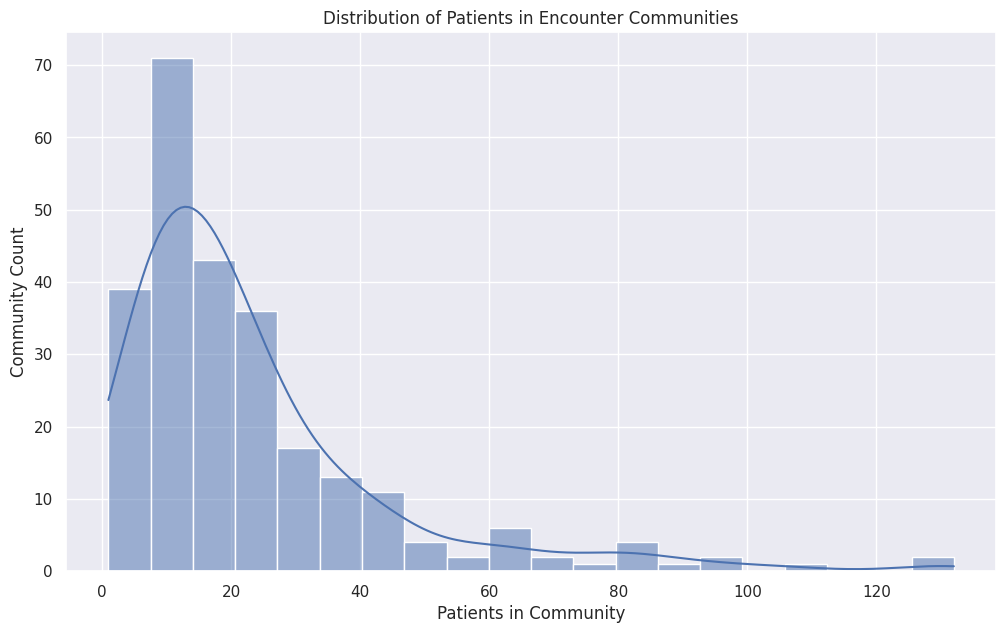

In [60]:
plot_patient_hist(df=encounter_medians_merged,
                  col='patientCount',
                  title='Distribution of Patients in Encounter Communities')

#### Communities Containing the Most Patients
Although we are using the 'medians' dataframe, the patient count is the true total.

In [61]:
encounter_medians_merged.sort_values(by=['patientCount'], ascending=False).head()

,totalEncounters,emergencyEncounters,encounterPageRank,patientCount
encounterCommunity,,,,
4918,36.0,1.0,0.958059,132
4883,14.0,1.0,0.949475,128
1892,40.0,1.0,0.947999,107
1764,55.0,2.0,0.867183,99
1014,22.0,1.0,0.964312,93


#### Communities with the Highest Median Total Encounters

In [62]:
encounter_medians_merged.sort_values(by=['totalEncounters'], ascending=False).head()

,totalEncounters,emergencyEncounters,encounterPageRank,patientCount
encounterCommunity,,,,
1250,966.0,189.0,0.994125,13
5293,894.0,19.0,0.809309,9
3569,869.0,5.0,0.962755,11
4393,771.0,5.0,0.963455,19
3746,724.0,6.0,1.027251,19


#### Communities with the Highest Median Emergency Encounters

In [63]:
encounter_medians_merged.sort_values(by=['emergencyEncounters'], ascending=False).head()

,totalEncounters,emergencyEncounters,encounterPageRank,patientCount
encounterCommunity,,,,
1250,966.0,189.0,0.994125,13
2626,78.0,45.0,0.912024,15
5390,325.0,36.0,0.866699,15
749,415.0,22.0,0.794094,5
2668,481.0,21.0,1.024378,27


#### Communities with the Highest Median Weighted PageRank
Communities with higher PageRank scores may be smaller than others, but at the same time very tight-knit.

In [64]:
encounter_medians_merged.sort_values(by=['encounterPageRank'], ascending=False).head()

,totalEncounters,emergencyEncounters,encounterPageRank,patientCount
encounterCommunity,,,,
4666,69.0,5.0,1.188782,7
1996,10.0,1.0,1.180030,20
2096,24.5,1.0,1.130502,6
2337,34.0,0.0,1.127463,12
5119,59.0,4.0,1.125023,9


# Patients to Procedures
In the following section we will replicate the Patients to Encounters workflow above, but this time with Patients to Procedures. All of the steps will be identical, except that the SNOMED_CT nodes represent Patient Procedures rather than Encounters.

## Create Bipartite Graph Projection

In [65]:
g, _ = gds.graph.project(
          graph_name = 'patient-procedure', 
          node_spec = ['Patient', 'SNOMED_CT'], 
          relationship_spec = ['PROCEDURE_CODE'],
          relationshipProperties = ['relCount'])

In [66]:
# view projection statistics
pd.DataFrame(_)[0][['nodeCount', 'relationshipCount']]

nodeCount              6400
relationshipCount    121558
Name: 0, dtype: object

## Run Node Similarity

In [67]:
_ = gds.nodeSimilarity.write(G = g, 
                             relationshipWeightProperty='relCount',
                             writeRelationshipType='PROCEDURE_SIMILARITY', 
                             writeProperty='similarityScore',
                             similarityCutoff=0.01, 
                             concurrency=4)

In [68]:
# view similarityScore distribution
pd.DataFrame(_)[0]['similarityDistribution']

{'p1': 0.5000028610229492,
 'max': 1.0000066757202148,
 'p5': 0.5932226181030273,
 'p90': 0.8813581466674805,
 'p50': 0.7777776718139648,
 'p95': 0.9230794906616211,
 'p10': 0.6400022506713867,
 'p75': 0.833003044128418,
 'p99': 1.0000066757202148,
 'p25': 0.7133779525756836,
 'p100': 1.0000066757202148,
 'min': 0.18181800842285156,
 'mean': 0.7702870410202757,
 'stdDev': 0.1016537232737979}

In [69]:
# drop projection 
_ = g.drop()

## Create Patient-Procedure Similarity Projection with Undirected Relationships

In [70]:
g, _ = gds.graph.project(
    graph_name = 'procedure-undirected', 
    node_spec = ['Patient'], 
    relationship_spec = {'PROCEDURE_SIMILARITY': {'orientation': 'UNDIRECTED'}},
    relationshipProperties = ['similarityScore'] 
)

## Identify Communities via Label Propagation

In [71]:
_ = gds.labelPropagation.write(G = g, 
                          relationshipWeightProperty = 'similarityScore',
                          writeProperty = 'procedureCommunity')

In [72]:
# view the community count and membership distribution 
pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]

communityCount                                                                                                                               217
communityDistribution    {'p99': 185, 'min': 1, 'max': 502, 'mean': 27.119815668202765, 'p90': 58, 'p50': 16, 'p999': 502, 'p95': 72, 'p75': 31}
Name: 0, dtype: object

##  Calculate a Procedure Weighted PageRank Score for Each Patient

In [73]:
_ = gds.pageRank.write(G=g, 
                   relationshipTypes=['PROCEDURE_SIMILARITY'], 
                   relationshipWeightProperty = 'similarityScore',
                   writeProperty='procedurePageRank')

In [74]:
# view the weighted PageRank score distribution 
pd.DataFrame(_)[0]['centralityDistribution']

{'p99': 2.0690908432006836,
 'min': 0.14999961853027344,
 'max': 2.844069480895996,
 'mean': 0.9595862956602085,
 'p90': 1.4572362899780273,
 'p50': 0.8874425888061523,
 'p999': 2.484786033630371,
 'p95': 1.6524267196655273,
 'p75': 1.1563405990600586}

## Generate Embeddings from Patient-Procedure Similarity Graph

In [75]:
_ = gds.fastRP.write(G=g,
                     nodeLabels=['Patient'],
                     relationshipTypes=['PROCEDURE_SIMILARITY'], 
                     relationshipWeightProperty="similarityScore",
                     writeProperty="procedureSimilarityEmbed",
                     randomSeed=42,
                     embeddingDimension=256)

In [76]:
_ = g.drop()

## Visualize Embeddings and Analyze Communities

In [77]:
patient_procedure_df = gds.run_cypher('''
MATCH (p:Patient)
RETURN
    p.id AS id,
    p.procedureCount AS procedureCount,
    p.procedureCommunity AS procedureCommunity,
    p.procedurePageRank AS procedurePageRank,
    p.procedureSimilarityEmbed AS procedureEmbedding
''')

patient_procedure_df.shape

(5885, 5)

### Subset Patient Community DataFrame
*Exclude embeddings because they are difficult to view in dataframe format*

In [78]:
# copy dataframe without embeddings 
procedure_community_df = patient_procedure_df[['id', 'procedureCount', 'procedureCommunity', 'procedurePageRank']].copy()
procedure_community_df.shape

(5885, 4)

In [79]:
# calculate median values for community statistics
median_procedure_df = procedure_community_df.groupby('procedureCommunity').median()
median_procedure_df.shape

(217, 2)

In [80]:
# generate community counts
procedure_patient_counts = procedure_community_df[['id', 'procedureCommunity']].groupby('procedureCommunity').count()
procedure_patient_counts.columns = ['patientCount']
procedure_patient_counts.shape

(217, 1)

In [81]:
# combine dataframes
procedure_medians_merged = median_procedure_df.merge(procedure_patient_counts, left_index=True, right_index=True)
procedure_medians_merged.shape

(217, 3)

### Subset Embeddings DataFrame

In [82]:
# create new dataframe containing only ids, community labels, and community embeddings
procedure_embedding_df = patient_procedure_df[['id', 'procedureCommunity', 'procedureEmbedding']].copy()
procedure_embedding_df['procedureCommunity'] = procedure_embedding_df['procedureCommunity'].astype(str)
procedure_embedding_df.shape

(5885, 3)

### Visualize Procedure Similarity Embeddings in 2D

In [83]:
procedure_2d_fig = plot_2d_embeddings(embedding_df=procedure_embedding_df,
                                      embeddings_col='procedureEmbedding',
                                      labels_col='procedureCommunity',
                                      plot_title='2D Visualization of Patient Procedure Similarity Embeddings')
procedure_2d_fig

### Visualize Procedure Similarity Embeddings in 3D

In [84]:
procedure_3d_fig = plot_3d_embeddings(embedding_df=procedure_embedding_df,
                                      embeddings_col='procedureEmbedding',
                                      labels_col='procedureCommunity',
                                      plot_title='3D Visualization of Patient Procedure Similarity Embeddings')
procedure_3d_fig

### Analyze Patient Procedure Communities
Similar to the analysis of Patient Encounters, we will use the total Procedure Count and weighted PageRank Score to identify communities of interest and visualize them in the embedding plots above. 

#### Plot Patient Count by Procedure Similarity Community

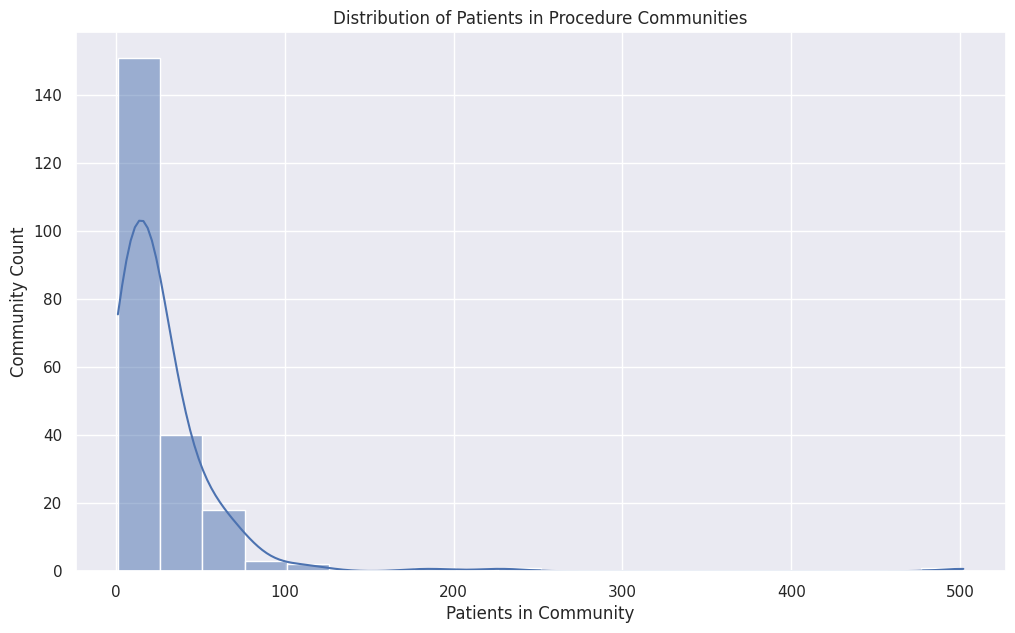

In [85]:
plot_patient_hist(df=procedure_medians_merged,
                  col='patientCount',
                  title='Distribution of Patients in Procedure Communities')

#### Communities Containing the Most Patients

In [86]:
procedure_medians_merged.sort_values(by=['patientCount'], ascending=False).head()

,procedureCount,procedurePageRank,patientCount
procedureCommunity,,,
5833,63.0,0.847382,502
3835,27.0,0.917159,228
2992,69.0,0.879122,185
4004,52.0,0.864447,115
4058,39.5,0.851222,110


#### Communities with the Highest Median Procedure Count

In [87]:
procedure_medians_merged.sort_values(by=['procedureCount'], ascending=False).head()

,procedureCount,procedurePageRank,patientCount
procedureCommunity,,,
1250,1152.5,0.885318,14
4815,1056.0,1.057818,15
3771,1046.0,0.832082,6
5198,879.5,0.908733,10
2281,865.5,1.115984,16


#### Communities with tbe Highest Median Weighted PageRank

In [88]:
procedure_medians_merged.sort_values(by=['procedurePageRank'], ascending=False).head()

,procedureCount,procedurePageRank,patientCount
procedureCommunity,,,
3906,384.0,1.236449,9
2686,67.5,1.165234,12
3759,25.0,1.157180,17
1386,9.0,1.153129,17
2281,865.5,1.115984,16


# Patients to Drugs
Finally, we will repeat the workflow for a third time to evaluate medications (drugs) prescribed and administered to patients. All steps will be identical to those performed with Patients to Encounters and Patients to Procedures.

## Create Bipartite Graph Projection

In [89]:
g, _ = gds.graph.project(
          graph_name = 'patient-drug', 
          node_spec = ['Patient', 'Drug'], 
          relationship_spec = ['DRUGS_PRESCRIBED'],
          relationshipProperties = ['relCount'])

## Run Node Similarity

In [90]:
_ = gds.nodeSimilarity.write(G = g, 
                             relationshipWeightProperty='relCount',
                             writeRelationshipType='DRUG_SIMILARITY', 
                             writeProperty='similarityScore',
                             similarityCutoff=0.01, 
                             concurrency=4)

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

In [91]:
# view similarityScore distribution
pd.DataFrame(_)[0]['similarityDistribution']

{'p1': 0.25000178813934326,
 'max': 1.0000075101852417,
 'p5': 0.3333338499069214,
 'p90': 0.928573489189148,
 'p50': 0.6027792692184448,
 'p95': 1.0000075101852417,
 'p10': 0.37500178813934326,
 'p75': 0.7500036954879761,
 'p99': 1.0000075101852417,
 'p25': 0.474359393119812,
 'p100': 1.0000075101852417,
 'min': 0.018867850303649902,
 'mean': 0.6200121346254084,
 'stdDev': 0.1984236709776194}

In [92]:
# drop projection 
_ = g.drop()

## Create Patient-Drug Similarity Projection with Undirected Relationships

In [93]:
g, _ = gds.graph.project(
          graph_name = 'drugs-undirected', 
          node_spec = ['Patient'], 
          relationship_spec = {'DRUG_SIMILARITY': {'orientation': 'UNDIRECTED'}},
          relationshipProperties = ['similarityScore'] 
)

In [94]:
# view projection statistics
pd.DataFrame(_)[0][['nodeCount', 'relationshipCount']]

nodeCount              5885
relationshipCount    112586
Name: 0, dtype: object

## Identify Communities via Label Propagation

In [95]:
_ = gds.labelPropagation.write(G = g, 
                          relationshipWeightProperty = 'similarityScore',
                          writeProperty = 'drugCommunity')

In [96]:
# view community statistics
pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]

communityCount                                                                                                                             572
communityDistribution    {'p99': 61, 'min': 1, 'max': 465, 'mean': 10.288461538461538, 'p90': 24, 'p50': 4, 'p999': 465, 'p95': 31, 'p75': 14}
Name: 0, dtype: object

## Calculate a Drug Weighted Page Rank Score for Each Patient

In [97]:
_ = gds.pageRank.write(G=g, 
                      relationshipTypes=['DRUG_SIMILARITY'], 
                      relationshipWeightProperty = 'similarityScore',
                      writeProperty='drugPageRank')

In [98]:
# view weighted PageRank score distribution
pd.DataFrame(_)[0]['centralityDistribution']

{'p99': 2.273848533630371,
 'min': 0.14999961853027344,
 'max': 5.463713645935059,
 'mean': 0.9262267987000912,
 'p90': 1.442854881286621,
 'p50': 0.8634099960327148,
 'p999': 5.116576194763184,
 'p95': 1.6299962997436523,
 'p75': 1.1440114974975586}

## Generate Embeddings from Patient-Encounter Similarity Graph

In [99]:
_ = gds.fastRP.write(G=g,
                     nodeLabels=['Patient'],
                     relationshipTypes=['DRUG_SIMILARITY'], 
                     relationshipWeightProperty="similarityScore",
                     writeProperty="drugSimilarityEmbed",
                     randomSeed=42,
                     embeddingDimension=256)

In [100]:
_ = g.drop()

## Visualize Embeddings and Analyze Communities

In [101]:
patient_drug_df = gds.run_cypher('''
MATCH (p:Patient)
RETURN
    p.id AS id,
    p.drugCount AS drugCount,
    p.drugCommunity AS drugCommunity,
    p.drugPageRank AS drugPageRank,
    p.drugSimilarityEmbed AS drugEmbedding
''')

patient_drug_df.shape

(5885, 5)

### Subset Patient Community DataFrame
*Exclude embeddings because they are difficult to view in dataframe format*

In [102]:
# copy dataframe without embeddings 
drug_community_df = patient_drug_df[['id', 'drugCount', 'drugCommunity', 'drugPageRank']].copy()
drug_community_df.shape

(5885, 4)

In [103]:
# calculate median values for community statistics
median_drug_df = drug_community_df.groupby('drugCommunity').median()
median_drug_df.shape

(572, 2)

In [104]:
# generate community counts
drug_patient_counts = drug_community_df[['id', 'drugCommunity']].groupby('drugCommunity').count()
drug_patient_counts.columns = ['patientCount']
drug_patient_counts.shape

(572, 1)

In [105]:
# combine dataframes
drug_medians_merged = median_drug_df.merge(drug_patient_counts, left_index=True, right_index=True)
drug_medians_merged.shape

(572, 3)

### Subset Embeddings DataFrame

In [106]:
# create new dataframe containing only ids, community labels, and community embeddings
drug_embedding_df = patient_drug_df[['id', 'drugCommunity', 'drugEmbedding']].copy()
drug_embedding_df['drugCommunity'] = drug_embedding_df['drugCommunity'].astype(str)
drug_embedding_df.shape

(5885, 3)

### Visualize Drug Similarity Embeddings in 2D

In [107]:
drug_2d_fig = plot_2d_embeddings(embedding_df=drug_embedding_df,
                                 embeddings_col='drugEmbedding',
                                 labels_col='drugCommunity',
                                 plot_title='2D Visualization of Patient Drug Similarity Embeddings')
drug_2d_fig

### Visualize Drug Similarity Embeddings in 3D

In [108]:
drug_3d_fig = plot_3d_embeddings(embedding_df=drug_embedding_df,
                                 embeddings_col='drugEmbedding',
                                 labels_col='drugCommunity',
                                 plot_title='3D Visualization of Patient Drug Similarity Embeddings')
drug_3d_fig

### Analyze Patient Drug Communities
Similar to the analysis of Patient Encounters and Procedures, we will use the total Drug (Medication) Count and weighted PageRank Score to identify communities of interest and visualize them in the embedding plots above. 

#### Plot Patient Count by Drug Similarity Community
The histogram below plots the number of patients per Drug Similarity community.

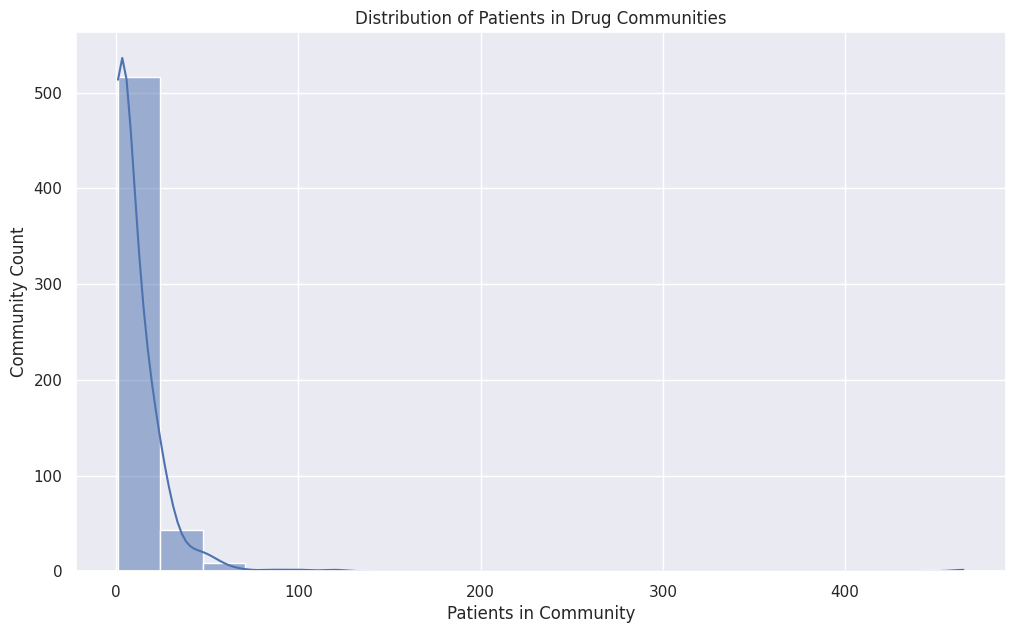

In [111]:
plot_patient_hist(df=drug_medians_merged,
                  col='patientCount',
                  title='Distribution of Patients in Drug Communities')

#### Communities Containing the Most Patients

In [112]:
drug_medians_merged.sort_values(by=['patientCount'], ascending=False).head()

,drugCount,drugPageRank,patientCount
drugCommunity,,,
619,7.0,0.845726,465
143,1.0,0.589714,120
3726,15.0,0.776882,101
1062,14.0,0.712551,86
191,7.0,0.794155,69


#### Communities with the Highest Median Total Encounters

In [113]:
drug_medians_merged.sort_values(by=['drugCount'], ascending=False).head()

,drugCount,drugPageRank,patientCount
drugCommunity,,,
4074,2679.5,0.813773,26
2097,1425.0,0.818478,6
4268,1352.5,1.140525,14
5478,1138.5,1.342056,14
4978,995.0,0.898773,7


#### Communities with Highest Median Weighted PageRank
Communities with higher PageRank scores may be smaller than others, but at the same time very tight-knit.

In [114]:
drug_medians_merged.sort_values(by=['drugPageRank'], ascending=False).head()

,drugCount,drugPageRank,patientCount
drugCommunity,,,
2440,4.0,1.448262,13
5478,1138.5,1.342056,14
704,4.0,1.287705,14
632,1.0,1.280370,16
773,1.0,1.272536,18


# Patient Journey Clustering Using KNN
Building upon all of our prior work, we will now use [K-Nearest Neighbors](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) algorithm to perform an overall similarity analysis of Patients in our data set. The Neo4j GDS implementation of KNN leverages node properties rather than relationships, which will provide a different approach to our analysis. However, by capturing embeddings from the Encounter, Procedure, and Drug similarity graphs, we will be able to incorporate graph structure 

## Create Graph Projection with Patient Properties

In [115]:
g, _ = gds.graph.project(
    graph_name = 'patient-journey-knn', 
    node_spec = ['Patient'], 
    nodeProperties = ['age',
                      'expenses',
                      'income',
                      'drugCount', 
                      'procedureCount',
                      'totalEncounters',
                      'emergencyEncounters',
                      'encounterSimilarityEmbed',
                      'procedureSimilarityEmbed',
                      'drugSimilarityEmbed'],
    relationship_spec = '*'
)

In [116]:
pd.DataFrame(_)[0][['nodeCount', 'relationshipCount']]

nodeCount              5885
relationshipCount    173873
Name: 0, dtype: object

## Scale Non-Embedding Node Properties
We will use the new [ScaleProperties](https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/scale-properties/) function in Neo4j to scale our non-mebedding properties. The function returns a property vector for each node in the graph projection. We can then uses these properties for distance-based clustering algorithms such as KNN.

In [117]:
_ = gds.alpha.scaleProperties.mutate(G = g, 
                                     nodeProperties = ['age',
                                                       'expenses',
                                                       'income',
                                                       'drugCount', 
                                                       'procedureCount',
                                                       'totalEncounters',
                                                       'emergencyEncounters'],
                                     scaler = 'MinMax',
                                     mutateProperty = 'scaledProperties')

In [118]:
# confirm properties written back to patient nodes
pd.DataFrame(_)[0]['nodePropertiesWritten']

5885

## Run KNN and Write Similarity Relationships to Graph

In [119]:
_ = gds.knn.write(G = g,
                  topK=25,
                  nodeProperties=['scaledProperties',
                                  'encounterSimilarityEmbed',
                                  'procedureSimilarityEmbed',
                                  'drugSimilarityEmbed'],
                  randomSeed=42,
                  concurrency=1,
                  writeRelationshipType="KNN_SIMILARITY",
                  writeProperty="similarityScore"
)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

In [120]:
# view similarity distribution 
pd.DataFrame(_)[0]['similarityDistribution']

{'p1': 0.6134166717529297,
 'max': 0.9955539703369141,
 'p5': 0.7122287750244141,
 'p90': 0.8521976470947266,
 'p50': 0.7773571014404297,
 'p95': 0.8749713897705078,
 'p10': 0.7335033416748047,
 'p75': 0.8154315948486328,
 'p99': 0.9380054473876953,
 'p25': 0.7514934539794922,
 'p100': 0.9955539703369141,
 'min': 0.38693809509277344,
 'mean': 0.7829772647413644,
 'stdDev': 0.05744872265394101}

In [121]:
# drop knn similarity graph
_ = g.drop()

## Create KNN Similarity Projection with Undirected Relationships

In [122]:
g, _ = gds.graph.project(
    graph_name = 'patient-knn-undirected', 
    node_spec = ['Patient'], 
    relationship_spec = {'KNN_SIMILARITY': {'orientation': 'UNDIRECTED'}},
    relationshipProperties = ['similarityScore'] 
)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [123]:
pd.DataFrame(_)[0][['nodeCount', 'relationshipCount']]

nodeCount              5885
relationshipCount    294250
Name: 0, dtype: object

## Identify Communities via Label Propagation

In [124]:
_ = gds.labelPropagation.write(G = g, 
                              relationshipWeightProperty = 'similarityScore',
                              writeProperty = 'knnCommunity')

In [125]:
pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]

communityCount                                                                                                                               138
communityDistribution    {'p99': 155, 'min': 6, 'max': 493, 'mean': 42.64492753623188, 'p90': 82, 'p50': 32, 'p999': 493, 'p95': 108, 'p75': 47}
Name: 0, dtype: object

## Run KNN Weighted Page Rank Score for Each Patient

In [126]:
_ = gds.pageRank.write(G=g, 
                   relationshipTypes=['KNN_SIMILARITY'], 
                   relationshipWeightProperty = 'similarityScore',
                   writeProperty='knnPageRank')

In [127]:
pd.DataFrame(_)[0]['centralityDistribution']

{'p99': 1.3983745574951172,
 'min': 0.44594764709472656,
 'max': 1.719076156616211,
 'mean': 0.9612404559969193,
 'p90': 1.1687908172607422,
 'p50': 0.9606761932373047,
 'p999': 1.5881099700927734,
 'p95': 1.2383174896240234,
 'p75': 1.070760726928711}

## Generate Embeddings from Patient KNN Similarity Graph

In [128]:
_ = gds.fastRP.write(G=g,
                     nodeLabels=['Patient'],
                     relationshipTypes=['KNN_SIMILARITY'], 
                     relationshipWeightProperty="similarityScore",
                     writeProperty="knnSimilarityEmbed",
                     randomSeed=42,
                     embeddingDimension=256)

In [129]:
_ = g.drop()

## Visualize KNN Patient Communities
The final section of this notebook will be similar to the visualization and analysis sections before. It demonstrates that you can capture embeddings from KNN and analyze them like we analyzed the Node Similarity-based embeddings.

In [130]:
patient_knn_df = gds.run_cypher('''
MATCH (p:Patient)
RETURN
    p.id AS id,
    p.age AS age,
    p.expenses AS expenses,
    p.income AS income,
    p.emergencyEncounters AS emergencyEncounters,
    p.totalEncounters AS totalEncounters,
    p.drugCount AS drugCount,
    p.procedureCount AS procedureCount,
    p.knnCommunity AS knnCommunity,
    p.knnPageRank AS knnPageRank,
    p.knnSimilarityEmbed AS knnEmbedding
''')

patient_knn_df.shape

(5885, 11)

### Subset Patient Community DataFrame
*Exclude embeddings because they are difficult to view in dataframe format*

In [140]:
list(patient_knn_df.columns)

['id',
 'age',
 'expenses',
 'income',
 'emergencyEncounters',
 'totalEncounters',
 'drugCount',
 'procedureCount',
 'knnCommunity',
 'knnPageRank',
 'knnEmbedding']

In [141]:
# copy dataframe without embeddings 
knn_community_df = patient_knn_df[['id',
                                   'age',
                                   'expenses',
                                   'income',
                                   'emergencyEncounters',
                                   'totalEncounters',
                                   'drugCount',
                                   'procedureCount',
                                   'knnCommunity',
                                   'knnPageRank']].copy()
knn_community_df.shape

(5885, 10)

In [142]:
# calculate median values for community statistics
median_knn_df = knn_community_df.groupby('knnCommunity').median()
median_knn_df.shape

(138, 8)

In [143]:
median_knn_df.head()

,age,expenses,income,emergencyEncounters,totalEncounters,drugCount,procedureCount,knnPageRank
knnCommunity,,,,,,,,
262,24.0,24965.630,71371.0,1.0,13.0,2.0,39.0,0.998519
398,35.5,38625.495,24523.5,8.0,52.0,3.0,54.0,1.039275
471,42.0,63005.035,67812.5,3.0,61.5,35.0,154.0,1.013033
509,8.0,9117.550,95022.0,1.0,34.0,27.0,13.0,1.005054
776,40.5,61156.615,56342.0,1.0,56.5,24.0,125.0,0.971770


In [144]:
# generate community counts
knn_patient_counts = knn_community_df[['id', 'knnCommunity']].groupby('knnCommunity').count()
knn_patient_counts.columns = ['patientCount']
knn_patient_counts.shape

(138, 1)

In [145]:
# combine dataframes
knn_medians_merged = median_knn_df.merge(knn_patient_counts, left_index=True, right_index=True)
knn_medians_merged.shape

(138, 9)

### Subset Embeddings DataFrame

In [146]:
# create new dataframe containing only ids, community labels, and community embeddings
knn_embedding_df = patient_knn_df[['id', 'knnCommunity', 'knnEmbedding']].copy()
knn_embedding_df['knnCommunity'] = knn_embedding_df['knnCommunity'].astype(str)
knn_embedding_df.shape

(5885, 3)

### Visualize Encounter Similarity Embeddings in 2D

In [147]:
knn_2d_fig = plot_2d_embeddings(embedding_df=knn_embedding_df,
                                embeddings_col='knnEmbedding',
                                labels_col='knnCommunity',
                                plot_title='2D Visualization of Patient Journey KNN Similarity Embeddings')
knn_2d_fig

### Visualize Encounter Similarity Embeddings in 3D

In [139]:
knn_3d_fig = plot_3d_embeddings(embedding_df=knn_embedding_df,
                                embeddings_col='knnEmbedding',
                                labels_col='knnCommunity',
                                plot_title='3D Visualization of Patient Journey KNN Similarity Embeddings')
knn_3d_fig

### Analyze Patient Encounter Communities
Similar to the analysis of Patient Encounters and Procedures, we will use the total Drug (Medication) Count and weighted PageRank Score to identify communities of interest and visualize them in the embedding plots above. 

#### Plot Patient Count by KNN Similarity Community
The histogram below plots the number of patients per Encounter Similarity community.

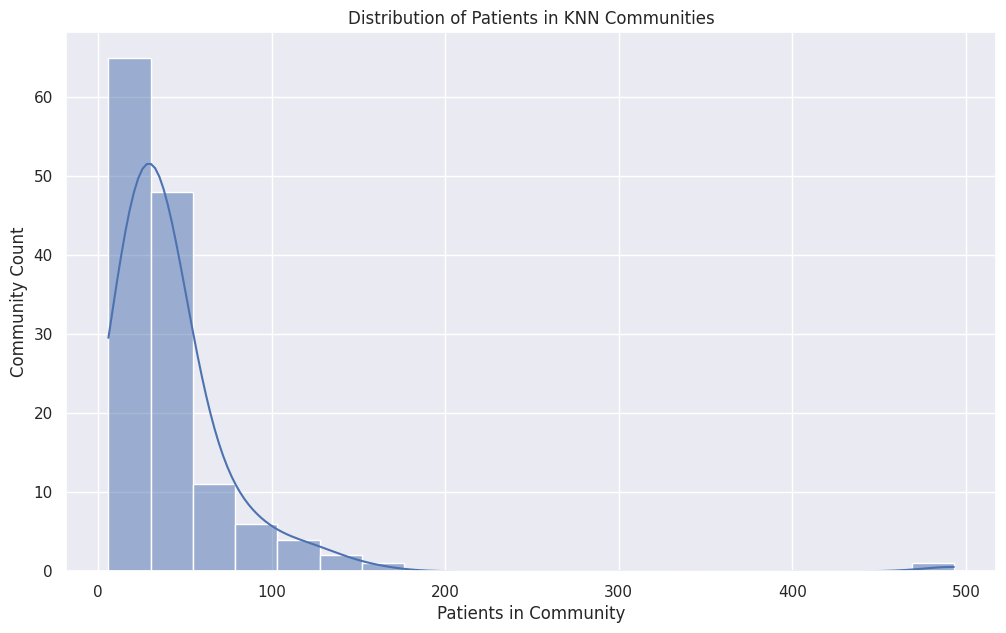

In [148]:
plot_patient_hist(df=knn_medians_merged,
                      col='patientCount',
                      title='Distribution of Patients in KNN Communities')

#### Communities Containing most Patients

In [149]:
knn_medians_merged.sort_values(by=['patientCount'], ascending=False).head()

,age,expenses,income,emergencyEncounters,totalEncounters,drugCount,procedureCount,knnPageRank,patientCount
knnCommunity,,,,,,,,,
1044,41.0,34270.93,68613.0,1.0,17.0,2.0,30.0,0.930947,493
1724,63.0,77841.05,60281.0,3.0,81.0,151.0,162.0,0.950592,155
3320,65.0,64871.95,86268.0,1.0,51.0,37.0,102.0,0.909444,129
4799,2.0,3830.80,81431.0,0.0,12.0,2.0,4.0,0.938252,129
5843,39.0,51529.72,59142.0,2.0,39.0,9.0,86.0,0.917937,123


#### Communities with Highest Median Expenses

In [150]:
knn_medians_merged.sort_values(by=['expenses'], ascending=False).head()

,age,expenses,income,emergencyEncounters,totalEncounters,drugCount,procedureCount,knnPageRank,patientCount
knnCommunity,,,,,,,,,
805,79.0,210158.46,96458.0,2.0,87.0,103.0,190.0,1.035546,33
4992,90.0,146510.94,48084.5,33.0,448.5,1449.5,839.5,0.943840,54
952,64.0,135088.68,22588.0,8.0,104.0,49.0,104.0,0.985813,47
3746,72.0,132314.13,98385.0,7.0,748.0,796.0,728.0,0.884306,17
2608,76.0,111863.77,62665.0,6.0,664.0,730.0,818.0,0.940884,35


#### Communities with Highest Median Income

In [151]:
knn_medians_merged.sort_values(by=['income'], ascending=False).head()

,age,expenses,income,emergencyEncounters,totalEncounters,drugCount,procedureCount,knnPageRank,patientCount
knnCommunity,,,,,,,,,
2399,56.5,53049.00,132587.5,1.0,37.0,37.0,73.0,0.964162,30
4275,41.0,51638.88,110256.0,1.0,26.0,16.0,59.0,0.994022,15
2509,13.0,16109.57,106542.5,1.0,32.5,4.0,27.5,0.876917,12
5732,54.0,52255.51,105892.0,1.0,38.0,43.0,68.0,1.039156,21
3556,34.0,40536.24,105835.5,3.0,46.0,7.0,127.0,0.974297,74


#### Communities with Highest Median Age

In [152]:
knn_medians_merged.sort_values(by=['age'], ascending=False).head()

,age,expenses,income,emergencyEncounters,totalEncounters,drugCount,procedureCount,knnPageRank,patientCount
knnCommunity,,,,,,,,,
2106,97.0,84192.88,74558.0,2.0,115.0,96.0,79.0,1.021176,39
2143,90.0,84725.80,60373.0,1.0,51.0,9.0,89.0,0.889243,25
4992,90.0,146510.94,48084.5,33.0,448.5,1449.5,839.5,0.943840,54
2009,90.0,101241.99,54516.0,17.0,605.0,948.0,866.0,0.982923,43
1602,84.0,82953.58,67259.0,2.0,82.0,108.0,87.0,0.906393,23


#### Communities with Highest Median Weighted PageRank
Communities with higher PageRank scores may be smaller than others, but at the same time very tight-knit.

In [153]:
knn_medians_merged.sort_values(by=['knnPageRank'], ascending=False).head()

,age,expenses,income,emergencyEncounters,totalEncounters,drugCount,procedureCount,knnPageRank,patientCount
knnCommunity,,,,,,,,,
2275,35.0,29675.55,65684.0,0.0,16.0,1.0,27.0,1.155120,43
3753,46.0,47141.07,84722.0,1.0,34.0,13.0,66.0,1.101681,47
2393,21.0,28804.81,68332.0,1.0,82.5,6.0,106.5,1.071433,52
3941,60.0,63321.07,60490.0,1.0,48.0,36.0,81.0,1.064748,21
4315,57.0,70737.58,56228.0,7.0,118.0,257.0,281.0,1.057722,25
